In [ ]:
!pip install -U tensorflow_datasets

In [2]:
import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
#Importing Pre-Dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='/root/tensorflow_datasets/fashion_mnist/3.0.1',
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
    

In [5]:
#metadata.features
classes = metadata.features['label'].names
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
# Explore Data
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data
The value of each pixel in the image data is an integer in the range [0,255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [7]:
def normalize(images,labels):
  images = tf.cast(images,tf.float32) #for typecasting the tensor
  images = images/255
  return images,labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

Coat


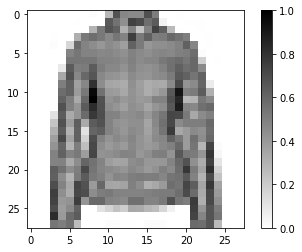

Coat


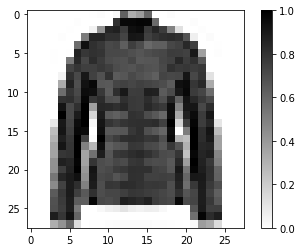

Ankle boot


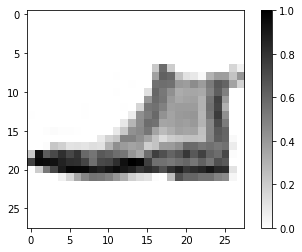

Sneaker


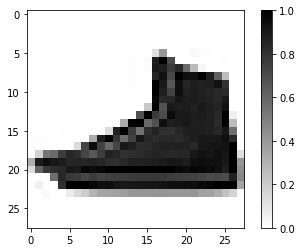

In [8]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(4): #takes the mentioned dataitems
  image = image.numpy().reshape((28,28)) # 28x28x1 dim to 28x28
  label = label.numpy()
  # break
    # print(image.shape, label.shape)
  print(classes[label])
  plt.figure()
  plt.imshow(image, cmap=plt.cm.binary)
  plt.colorbar()
  plt.grid(False)
  plt.show()


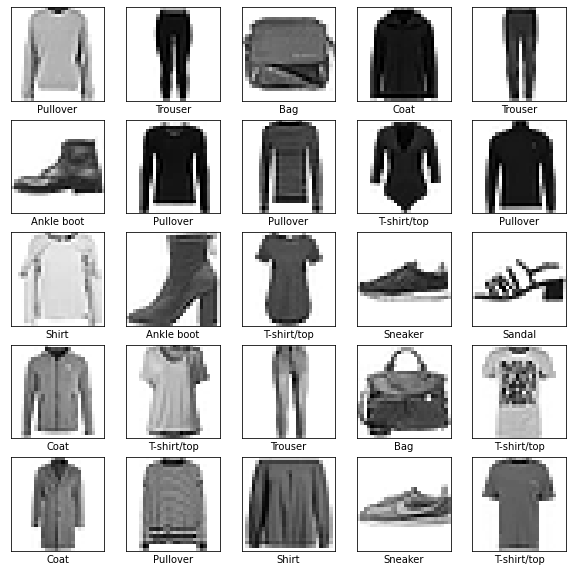

In [9]:
# Display first 25 items in train
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(classes[label])
plt.show()

## Building Models


In [10]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape = (28,28,1)),
                             tf.keras.layers.Dense(256,activation=tf.nn.relu),
                             tf.keras.layers.Dense(128,activation=tf.nn.relu),
                             tf.keras.layers.Dense(64,activation=tf.nn.relu),
                             tf.keras.layers.Dense(10,activation=tf.nn.softmax),                                
])

#Pytorch
# model = nn.Sequential(nn.Linear(784,256),
#                       nn.ReLU(),
#                       nn.Linear(256,128),
#                       nn.ReLU(),
#                       nn.Linear(128,64),
#                       nn.ReLU(),
#                       nn.Linear(64,10),
#                       nn.LogSoftmax(dim = 1)
#                       )
model

## Complie

- Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
- Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
- Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Pytorch
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.003)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


## Train the model

- Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).
- The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples.
And dataset.
- batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the model.fit method:

- Feed the training data to the model using train_dataset.
- The model learns to associate images and labels.
The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 14s 4ms/step - loss: 0.4773 - accuracy: 0.8261
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3595 - accuracy: 0.8683
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3270 - accuracy: 0.8773
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3042 - accuracy: 0.8873
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2872 - accuracy: 0.8925


## Evaluate

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.3543 - accuracy: 0.8729
Accuracy on test dataset: 0.8729000091552734


## Make Predictions

In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [17]:
predictions.shape

(32, 10)

In [18]:
predictions[0]

array([4.0462353e-05, 1.5532891e-06, 1.6111344e-02, 7.2453628e-07,
       9.5656598e-01, 1.8601625e-08, 2.7266208e-02, 4.9032032e-08,
       1.3342445e-05, 2.5714286e-07], dtype=float32)

In [19]:
np.argmax(predictions[0])

4

In [20]:
classes[np.argmax(predictions[0])] 

'Coat'

In [21]:
test_labels[0]

4

In [24]:
class_names = classes
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

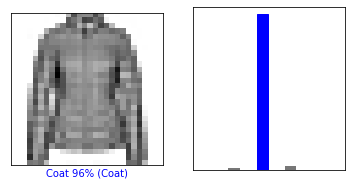

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

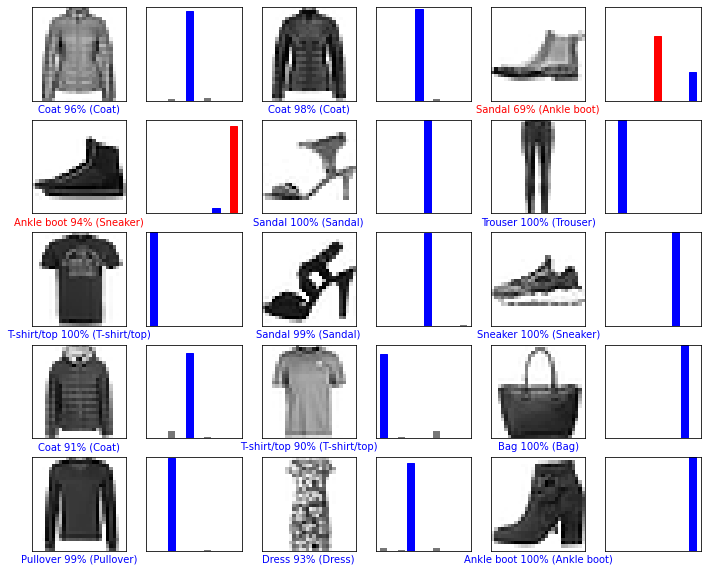

In [26]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [27]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [28]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [29]:
predictions_single = model.predict(img)

print(predictions_single)

[[4.0462353e-05 1.5532875e-06 1.6111344e-02 7.2453628e-07 9.5656598e-01
  1.8601694e-08 2.7266223e-02 4.9032032e-08 1.3342432e-05 2.5714286e-07]]


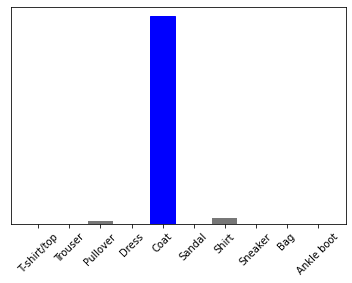

In [30]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [32]:
classes[np.argmax(predictions_single[0])]

'Coat'